# Power Spectrum
---
This is a Python code for an introduction into some basic FFT calculation methods, particularly focusing on power-spectrum and power-spectral density. Using it shall make understanding of the data-analysis paper more easier.

### Loading Modules and Using LaTeX

In [55]:
import numpy as np
import scipy.signal as scisig
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "DejaVu Sans"
})

## Creating Time-Data (Waveforms)

When doing simulations using Fourier transformation, we usually need proper data in time-domain to play with. Of course we are not restricted to the kind of data we want to use. So, in general, we could also utilize real-measured data. However, for the sake of flexibility and educational purpose, we will produce (simulate) our own waveform with the aid of a Python function:

In [56]:
def Sine_Signal(t, A, f, n):
    np.random.seed()
    R = [np.random.normal(scale = np.sqrt(n)) for i in range(len(t))]
    S = [A*np.sin(2*np.pi*f*t[i]) + R[i] for i in range(len(t))]
    return S

where our signal is a simple sine, described as
$$
S(t) = A\cdot\sin(2\pi f\cdot t).
$$
As can be seen, the data will be noisy, whereas Gaussian-noise is added to the sine signal. The parameter $n$ is hereby the noise power density which is related to the data's variance via:
$$
\sigma^2 = \frac{n}{2\pi}\cdot\int_{0}^{\omega_0}d\omega,
$$
whereas $\omega_0$ is the bandwidth of the signal (ideally $\infty$).

Let's see how our data look like:

In [57]:
T = 5
dt = 0.01
t = np.arange(0, T, dt)
A = 1
fsampling = 1/dt
n = 1e-1 * fsampling/2
f = 5
y = Sine_Signal(t, A, f, n)

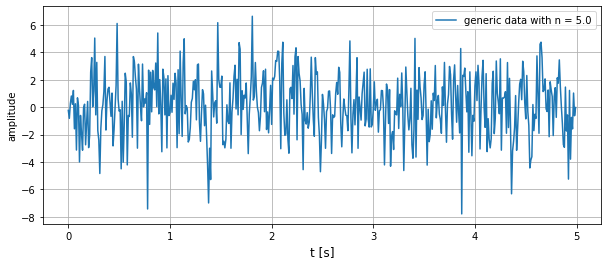

In [58]:
plt.figure(figsize = (10,4))
plt.plot(t, y, label = "generic data with n = "+str(n))
plt.xlabel('t [s]', fontsize = 12)
plt.ylabel('amplitude')
plt.grid(True)
plt.legend()
plt.show()

## Power Spectral Density (PSD)

The above defined data-stream $y(t)$ is what we want to analyze. The goal is to retrieve an estimation of the signal's amplitude, its frequency and the variance of the noise. These information are all included in a Fourier-transform, a.k.a the spectrum of the data.

The Fourier-transform is mathematically defined as
$$
y(f) = \frac{1}{\sqrt{T}}\cdot\int_{-\infty}^{\infty} y(t)\cdot e^{-i\omega t} dt
$$
and produces a complex expression which is a function of the frequency $f = \omega/2\pi$.

A Fourier-transform with discrete data (i.e., $y(t) = y(t_i)$ for $i = 1,...,N$; $N \in\mathbb{N}$) can be easily calculated using summation. However, for large data-files, this can become a quite time-consuming procedure. It is thus more efficient to use the **fft** method (fast-fourier-transform). The numpy module has this method already included so that we can write:

In [59]:
y_fft = np.fft.fft(y, norm=None)

That expression can be visalized in 2D (as it is complex):

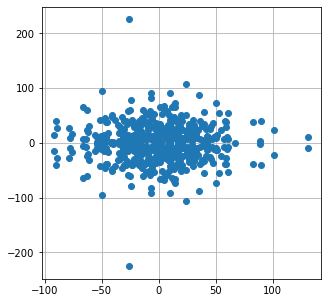

In [60]:
plt.figure(figsize = (5,5))
plt.plot(np.real(y_fft), np.imag(y_fft), linewidth = 0, marker = "o")
plt.grid(True)
plt.show()

This "spectrum" doesn't have a form yet from which we could extract valuable information. We see, however, that it contains already two mirrored distributions, which is generally what we would expect from a spectrum since it is supposed to cover both negative and positive frequencies even though the information for both is the same.

In order to bring it in a better readable form, we have to take the magnitude of each value and define the (positive) frequency space:

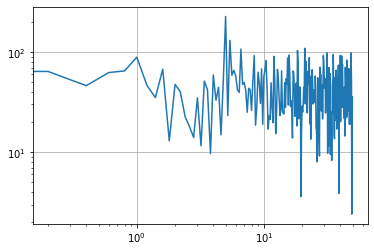

In [61]:
f = np.arange(0, fsampling/2, 1/T)
y_spectrum = abs(y_fft[:int(len(y_fft)/2)])

plt.figure()
plt.loglog(f, y_spectrum)
plt.grid(True)
plt.show()

This spectrum shows us already the position of the signal with the correct frequency but it lacks a valuable amplitude representation as it is right now basically a counter for correlation events. In order to get to such a representation, we will have to start from **Parseval's theorem**.
In fact, that theorem is basically a statement of energy (or power) conservation: the power stored in the time regime shall equal the power stored in the frequency regime: 
$$
\sum{y(t)^2} = \sum{y(f)^2}.
$$
This equality is of course also true for the mean squared amplitude:
$$
\sum{\frac{y(t)^2}{N}} = \sum{\frac{y(f)^2}{N}}
$$
which gives the mean power of the signal in time and frequency regime. 

The fft-function above gives the non-normalized Fourier transform. That is because the function only takes the data as input while ignoring time-sampling. Translated into the DFT (Discrete Fourier Transform), it means that $\Delta t = 1$. We thus have to include the time-sampling into the fft to get the correct normalization. We can do this by putting $\Delta t/\sqrt{T}$ as a factor in front of the fft ($\sqrt{T}$ is needed in order to orthogonalize both the time and frequency domain, otherwise Parseval's theorem demands a factor $1/T$ for the time-domain).
Then, multiplying the fft with its complex conjugate results in $y(f)^2$, which is of course nothing else than a spectral density for the power as we have to take the integral over the whole spectral range to get that power. Thus **power spectral density (PSD)**.

Note: Parsival's theorem is valid only if the Fourier transform of a signal exists, which is mathematically spoken not always the case.
Also, if we have a non-continuous signal, the peaks and their widths in the power-spectrum will depend strongly on the lenght of the time-frame. 

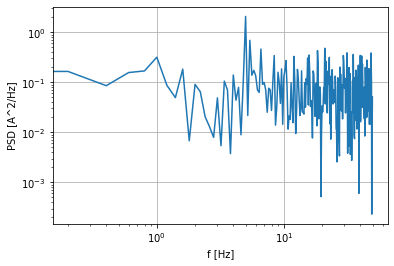

In [62]:
y_psd = abs(y_fft * np.conjugate(y_fft)) * 2 * (dt/np.sqrt(T))**2

plt.figure()
plt.loglog(f, y_psd[:int(len(f))])
plt.grid(True)
plt.xlabel('f [Hz]')
plt.ylabel('PSD [A^2/Hz]')
plt.show()

Integrating (summing) $y_\text{psd}$ over the whole bandwidth will result in an estimation of the containing power. Multiplying $y_\text{psd}$ with the frequency resolution on the other side, will result in the **power spectrum** which indicates how much power is stored per frequency bin and which is thus also an estimator for the amplitude of a single-frequency signal.

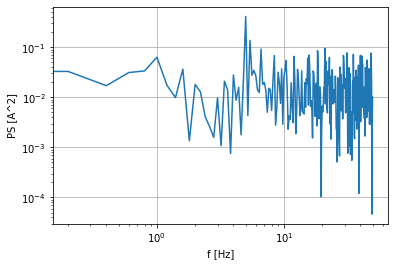

In [63]:
y_ps = y_psd * 1/T

plt.figure()
plt.loglog(f, y_ps[:int(len(f))])
plt.grid(True)
plt.xlabel('f [Hz]')
plt.ylabel('PS [A^2]')
plt.show()

The peak at 5 Hz is located at $\sim 4$ $[A^2]$, which results in an amplitude of a sine
$$
\hat{A} = \frac{\sqrt{y_\text{psd}(f_0 = 5\text{Hz})}}{2}
$$
of $\sim 1$, as expected.

## Variance and Noise Spectral Density

One of the merits of a PSD is its tight connection to underlying noise, which is in our case white Gaussian. As a parameter for the strength of noise, generally the variance $\sigma^2$ is being used. It is the, so called, second central moment of a data-stream, defined as
$$
\sigma^2 = \sum_{i}{\frac{(y(t_i) - \mu_y)^2}{N}}
$$
with $\mu_y$ being the mean value of the data-stream (which is approximately zero in our case).
In the definition of the waveform, we have used the parameter $n$ to set the variance. We will rewrite it here to
$$
n = N_0\cdot \frac{f_\text{sampling}}{2},
$$
where in our case $N_0 = 0.1$ is the **noise spectral density**.

So far about the settings. But what if we want to know this kind of information from the data-stream?
As can be recognized already from the PSD spectrum, the mean value of $y_\text{psd}$ is approximately $N_0$ and this follows indeed from its definition as being as spectral density: in the ideal case, the PSD of a pure Gaussian process is a constant with value $N_0$. In our example, we have only a limited time-range and sampling for the data-stream. Hence, cross-correlations exist for each frequency with other frequencies which appear as "noise" in the spectrum. However, if we take the mean of $y_\text{psd}$, we can still get a fairly good estimation of $N_0$ and thus $\sigma^2$:

In [64]:
print("variance = "+str(sum(np.array(y)**2)/len(y)))
print("noise spectral density = "+str(sum(y_psd)/len(y_psd)))

variance = 5.0545814499716695
noise spectral density = 0.10109162899943334
